#                        - Computational Neuroscience 2021-2022 Final Project -        

##   Project Name: Combinatorial Codes in Ventral Temporal Lobe for Visual Object Recognition



The functional architecture of the object vision pathway in the human brain was
investigated using functional magnetic resonance imaging to measure patterns
of response in ventral temporal cortex while subjects viewed faces, cats, Þve
categories of man-made objects, and nonsense pictures. A distinct pattern of
response was found for each stimulus category. The distinctiveness of the
response to a given category was not due simply to the regions that responded
maximally to that category, because the category being viewed also could be
identiÞed on the basis of the pattern of response when those regions were
excluded from the analysis. Patterns of response that discriminated among all
categories were found even within cortical regions that responded maximally
to only one category. These results indicate that the representations of faces
and objects in ventral temporal cortex are widely distributed and overlapping.


Filename       : CompNeuro_2021-2022_Final_Project.ipynb

Authors        : Arman Vural Budunoğlu and Can Kocagil

Institution    : Bilkent University Departman of Electric & Electronical Enginering

Class          : EEE482/582 - Computational Neuroscience 

Project Goal   : Implement multi-voxel pattern analyses methods (based on some type of classifier) to
                 decode the category of visual stimuli viewed by a human subject based on their recorded brain activity
                 
Dataset Link   : https://openfmri.org/dataset/ds000105.

Related Papers : Distributed and overlapping representations of faces and objects in ventral temporal cortex

Abstract:

    The functional architecture of the object vision pathway in the human brain was
    investigated using functional magnetic resonance imaging to measure patterns
    of response in ventral temporal cortex while subjects viewed faces, cats, Þve
    categories of man-made objects, and nonsense pictures. A distinct pattern of
    response was found for each stimulus category. The distinctiveness of the
    response to a given category was not due simply to the regions that responded
    maximally to that category, because the category being viewed also could be
    identiÞed on the basis of the pattern of response when those regions were
    excluded from the analysis. Patterns of response that discriminated among all
    categories were found even within cortical regions that responded maximally
    to only one category. These results indicate that the representations of faces
    and objects in ventral temporal cortex are widely distributed and overlapping.

Pipeline:
    
    1) Necessary Installations (If necessary)
    2) Imports
    3) Visual Stimuli and Category Loading
    4) Visual Stimuli Transformations
    5) Explanatory Visual Stimuli Analysis
        
        * PCA
        * T-Stochastic Neighboor Embedding (t-SNE)
        * Linear Discriminate Analysis
        * Uniform Manifold Approximation and Projection (UMAP)
        * Independent Component Analysis (ICA)
        * Non-Negative Matrix Factorization
        * Masking
        
    6) Visual Stimuli Similarity Analysis
    
        * Euclidean Similarity
        * Cosine Similarity
        * Pearson Correlation             
        
    7) Classical ML Algorithms:
    
        * LinearSVC
        * SGDClassifier
        * MLPClassifier
        * Perceptron
        * LogisticRegression
        * LogisticRegressionCV
        * SVC
        * CalibratedClassifierCV
        * PassiveAggressiveClassifier
        * LabelPropagation
        * LabelSpreading
        * RandomForestClassifier
        * GradientBoostingClassifier
        * QuadraticDiscriminantAnalysis
        * RidgeClassifierCV
        * RidgeClassifier
        * AdaBoostClassifier
        * ExtraTreesClassifier
        * KNeighborsClassifier
        * BaggingClassifier
        * BernoulliNB
        * LinearDiscriminantAnalysis
        * GaussianNB
        * NuSVC
        * DecisionTreeClassifier
        * NearestCentroid
        * ExtraTreeClassifier
        * CheckingClassifier
        * DummyClassifier
        
    7) Reported Metrics
        * Accuracy
        * Balanced Accuracy
        * ROC AUC
        * F1-Score
        * Time Taken
        
    8) Deep Learning Algorithms
        * 3-D Convolutional Neural Networks
        * Visual Transformers
        * ...
        
    9) Results Interpretation
    





# Necessary Installations (If necessary)

In [1]:
!pip install umap
!pip install pipreqs
!pip install lazypredict
!pip install nibabel
!pip install nilearn
!pip install -U kaleido


try:
    import sklearn
    print('Scikit-learn is available, version', sklearn.__version__)
    
except:
    !pip install scikit-learn
    
 
try:
    import cv2
    print('Open-CV is available, version', cv2.__version__)
    
except:
     !pip install opencv-python
    
   
try:
    import seaborn
    print('Seaborn is available, version', seaborn.__version__)
    
except:
     !pip install seaborn


Scikit-learn is available, version 0.23.1
Open-CV is available, version 4.5.1
Seaborn is available, version 0.11.0


# Imports

In [1]:
from __future__ import print_function, division

# Basics:
import numpy as np,pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import os, random, time, sys, copy, math, pickle

# interactive mode
plt.ion()

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# For plotting
import plotly.io as plt_io
import plotly.graph_objects as go
%matplotlib inline

# Dimension Reduction Algorithms:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import FastICA
from sklearn.decomposition import NMF
import umap

# Transformations
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Metrics:
from sklearn.metrics import classification_report

# Train-Test Splitter:
from sklearn.model_selection import train_test_split

# For Classical ML algorithms:
from lazypredict.Supervised import LazyClassifier

# Utilies:
from tqdm import tqdm

# For distance measurements:
from scipy.spatial.distance import cdist

# Extras:
from abc import abstractmethod
from typing import Callable, Iterable, List, Tuple

# Set true for Google Colab:
COLAB = False

if COLAB:
    # To access Google Drive:
    from google.colab import drive
    drive.mount("/content/gdrive")

    
# For neuroimaging:
from nibabel.testing import data_path
from nilearn import plotting as nplt
from nilearn.input_data import NiftiMasker
from nilearn import datasets
from nilearn import plotting
from nilearn.image import mean_img
from nilearn.image import index_img
import nibabel as nib
from nilearn import image



print("NumPy Version: ", np.__version__)


root_dir = os.getcwd()
image_results_dir = os.path.join(root_dir, 'images')
results_dir = os.path.join(root_dir, 'results')

print('Working Directory: \n ', root_dir)


# Creating requirements.txt file
!pip3 freeze > requirements.txt  

NumPy Version:  1.19.1
Working Directory: 
  C:\Users\Administrator\Desktop\VOR


# Utilities

In [2]:
from utils.timers import timeit
from utils.metrics import accuracy, confusion_matrix, visualize_confusion_matrix
from utils.savers import save, save_obj, load, load_obj
from utils.reproduce import random_seed
from dataset.fetch_data_matrix import fetch_from_haxby
from visualizer.plot2D import plot_2d
from visualizer.plot3D import plot_3d  

# $  \:\:\:\:\:\:\:$  fMRI Spatio Temporal Data and Visual Stimuli Category Loading

$\textbf{Experimental View of the Haxby (Faces and Objects in Ventral Temporal Cortex (fMRI)) Dataset:}$  This is a block-design fMRI dataset (Haxby) from a study on face and object representation in human ventral temporal cortex. It consists of 6 subjects with 12 runs per subject. In each run, the subjects passively viewed greyscale images of eight object categories, grouped in 24s blocks separated by rest periods. Each image was shown for 500ms and was followed by a 1500ms inter-stimulus interval. Full-brain fMRI data were recorded with a volume repetition time of 2.5s, thus, a stimulus block was covered by roughly 9 volumes.

---
$\textbf{Dataset Description:}$

1. anat.nii.gz

- High resolution anatomical image. For subject 6 there is no anatomical image available.

2.bold.nii.gz
    
- 4D fMRI timeseries image. (1452 volumes with 40 x 64 x 64 voxels, corresponding to a voxel size of 3.5 x 3.75 x 3.75 mm and a volume repetition time of 2.5 seconds). The timeseries contains all 12 runs of the original experiment, concatenated in a single file. Please note, that the timeseries signal is not detrended.

3.mask*.nii.gz

- Various masks in functional space provided by the original authors. “vt” refers to “ventral temporal”, “face” and “house” masks are GLM contrast based localizer maps.

4.labels.txt

- A two-column text file with the stimulation condition and the corresponding experimental run for each volume in the timeseries image. Labels are given in literal form (e.g. ‘face’).

---

We have 8 different stimuli categories that are :  $\textbf{scissors, face, cat, scrambledpix, bottle, chair, shoe, house}$. We'll work with haxby dataset that can be downloaded directly from the neuroimaging library Nilearn. There are 6 subjects in the experiment that will be downloaded seperately with their fMRI images and masks. These fMRI images are 4-D nifti images.

In [3]:
# There are 6 number of subjects in the experiment: 
haxby_dataset = datasets.fetch_haxby(subjects= [1,2,3,4,5,6])

In [4]:
haxby_dataset

{'anat': ['C:\\Users\\Administrator/nilearn_data\\haxby2001\\subj1\\anat.nii.gz',
  'C:\\Users\\Administrator/nilearn_data\\haxby2001\\subj2\\anat.nii.gz',
  'C:\\Users\\Administrator/nilearn_data\\haxby2001\\subj3\\anat.nii.gz',
  'C:\\Users\\Administrator/nilearn_data\\haxby2001\\subj4\\anat.nii.gz',
  'C:\\Users\\Administrator/nilearn_data\\haxby2001\\subj5\\anat.nii.gz',
  None],
 'func': ['C:\\Users\\Administrator/nilearn_data\\haxby2001\\subj1\\bold.nii.gz',
  'C:\\Users\\Administrator/nilearn_data\\haxby2001\\subj2\\bold.nii.gz',
  'C:\\Users\\Administrator/nilearn_data\\haxby2001\\subj3\\bold.nii.gz',
  'C:\\Users\\Administrator/nilearn_data\\haxby2001\\subj4\\bold.nii.gz',
  'C:\\Users\\Administrator/nilearn_data\\haxby2001\\subj5\\bold.nii.gz',
  'C:\\Users\\Administrator/nilearn_data\\haxby2001\\subj6\\bold.nii.gz'],
 'session_target': ['C:\\Users\\Administrator/nilearn_data\\haxby2001\\subj1\\labels.txt',
  'C:\\Users\\Administrator/nilearn_data\\haxby2001\\subj2\\labels.tx

In [435]:
num_subjects = 6

for subject in range(num_subjects):   

    # 'func' is a list of filenames: one for each subject
    fmri_filename = haxby_dataset.func[subject]

    # print basic information on the dataset
    print('First subject functional nifti images (4D) are at: %s' %
          fmri_filename)  # 4D data

First subject functional nifti images (4D) are at: C:\Users\Administrator/nilearn_data\haxby2001\subj1\bold.nii.gz
First subject functional nifti images (4D) are at: C:\Users\Administrator/nilearn_data\haxby2001\subj2\bold.nii.gz
First subject functional nifti images (4D) are at: C:\Users\Administrator/nilearn_data\haxby2001\subj3\bold.nii.gz
First subject functional nifti images (4D) are at: C:\Users\Administrator/nilearn_data\haxby2001\subj4\bold.nii.gz
First subject functional nifti images (4D) are at: C:\Users\Administrator/nilearn_data\haxby2001\subj5\bold.nii.gz
First subject functional nifti images (4D) are at: C:\Users\Administrator/nilearn_data\haxby2001\subj6\bold.nii.gz


# Explanatory Visual Stimuli Analysis

## Echo-planar imaging (EPI) Averaging for 4-D Visualization of the fMRI Nifti Image

In [ ]:
%%time

explanatory_fMRI_dir = os.path.join(image_results_dir, 'explanatory')

# cut in x-direction
sagittal = -25
# cut in y-direction
coronal = -37
# cut in z-direction
axial = -6

# coordinates displaying should be prepared as a list
cut_coords = [sagittal, coronal, axial]


# Echo-planar imaging (EPI) Averaged for 4-D
epi_image = mean_img(fmri_filename)

plotting.view_img(epi_image,
                  threshold=None,
                  title = 'fMRI Volume',
                  output_file = os.path.join(explanatory_fMRI_dir + 'fMRI_volume.png'),)

## A mask of the Ventral Temporal (VT) cortex with egion of Interest (RoI) 

In [27]:
from visualizer.roi import RoI_visualizer

In [23]:
def RoI_visualizer(haxby_dataset = haxby_dataset, subject_id:int = random.randint(0,5)) -> None:
    """
        Given the subject id from i = 1,...,6, visualize the a mask of the Ventral Temporal (VT) cortex,
        coming from the Haxby with the Region of Interest (RoI) 
        
        Arguments:
        
            subject_id (int) = Subject number 
            
        Returns:
            - None  
    """
    
    # Subject ID from i = 0,...,5:
    # subject_id = 3

    # Get mask filename:
    mask_filename = haxby_dataset.mask_vt[subject_id]


    # Region of Interest Visualizations:
    plotting.plot_roi(mask_filename,
                      bg_img=haxby_dataset.anat[subject_id],
                      cmap='Paired',
                      title = f'Region of Interest of subject {subject_id}',
                      figure= plt.figure(figsize=(12,4)),
                      alpha=0.7,
                      #output_file = os.path.join(explanatory_fMRI_dir, 'roi.png'
                      )

    plotting.show()

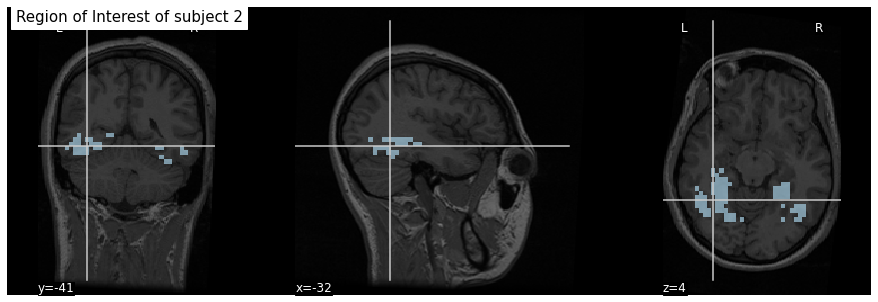

In [24]:
RoI_visualizer(subject_id=2)

## Statistical Maps

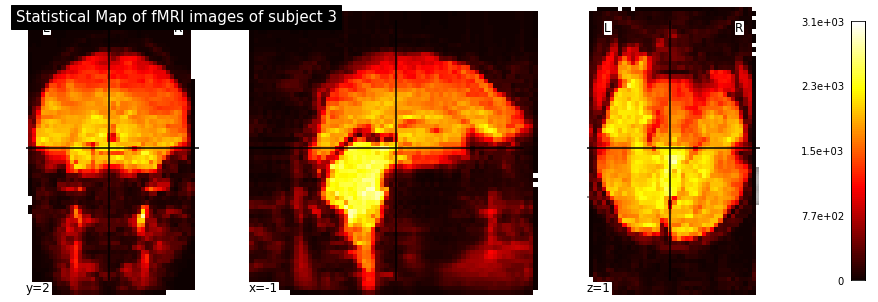

In [19]:
subject_id =  3

plotting.plot_stat_map(mean_img(fmri_filename),
                       threshold=3,
                       figure=plt.figure(figsize=(12,4)),
                       title=f'Statistical Map of fMRI images of subject {subject_id}',
                       #output_file = os.path.join(explanatory_fMRI_dir, 'stats_map.png')
                       )
plt.show()

## Simple, Compact, fMRI Visualizations 

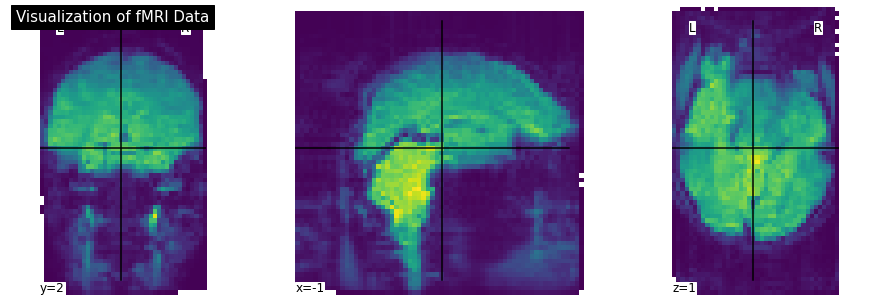

In [27]:
plotting.plot_img(mean_img(fmri_filename),
                 cut_coords=None,
                 #output_file= os.path.join(explanatory_fMRI_dir, 'fMRI.png'),
                 display_mode='ortho',
                 figure=plt.figure(figsize = (12,4)),
                 axes=None,
                 title='Visualization of fMRI Data',
                 threshold=3,
                 annotate=True,
                 draw_cross=True,
                 black_bg=False,
                 colorbar=False)
plt.show()

## EPI Plotting 

In [28]:
plotting.plot_epi(mean_img(fmri_filename),
                  title='Smoothed mean EPI',
                  cut_coords=cut_coords,
                  #output_file= os.path.join(explanatory_fMRI_dir, 'epi.png')
                 )

## Anatomic fMRI Visualizations

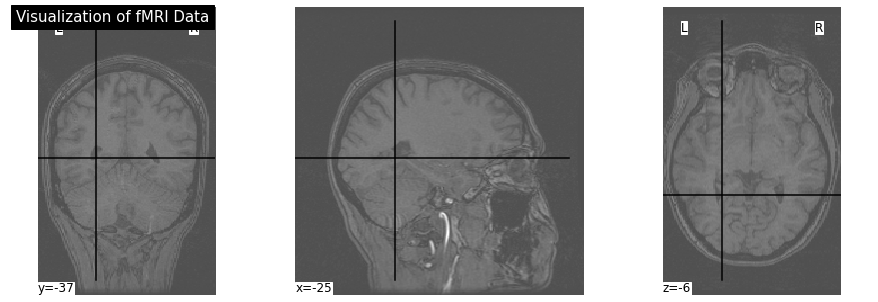

In [31]:
plotting.plot_anat(haxby_dataset.anat[0],
                  cut_coords=cut_coords,
                  #output_file= os.path.join(explanatory_fMRI_dir, 'anat.png'),
                  display_mode='ortho',
                  figure=plt.figure(figsize = (12,4)),
                  axes=None,
                 title='Visualization of fMRI Data',
                 threshold=None,
                 annotate=True,
                 draw_cross=True,
                 black_bg=False,
                 colorbar=False)
plotting.show()

In [ ]:
plotting.plot_anat(mean_img(fmri_filename),
                  cut_coords=None,
                  output_file=None,
                  display_mode='ortho',
                  figure=plt.figure(figsize = (12,4)),
                  axes=None,
                  title='Visualization of fMRI Data',
                  threshold=None,
                  annotate=True,
                  draw_cross=True,
                  black_bg=False,
                  colorbar=False)
plotting.show()

## Plot Haxby masks 

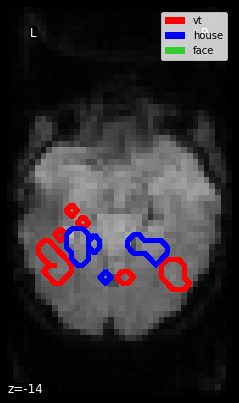

In [33]:
# Build the mean image because we have no anatomic data


func_filename = haxby_dataset.func[0]
_mean_img = image.mean_img(func_filename)

z_slice = -14

fig = plt.figure(figsize=(4, 5.4), facecolor='k')

from nilearn.plotting import plot_anat, show

display = plot_anat(_mean_img, display_mode='z', cut_coords=[z_slice],
                    figure=fig)

mask_vt_filename = haxby_dataset.mask_vt[0]
mask_house_filename = haxby_dataset.mask_house[0]
mask_face_filename = haxby_dataset.mask_face[0]

display.add_contours(mask_vt_filename,
                     contours=1,
                     antialiased=False,
                     linewidths=4.,
                     levels=[0],
                     colors=['red'])
display.add_contours(mask_house_filename,
                     contours=1,
                     antialiased=False,
                     linewidths=4.,
                     levels=[0],
                     colors=['blue'])
display.add_contours(mask_face_filename,
                     contours=1,
                     antialiased=False,
                     linewidths=4.,
                     levels=[0],
                     colors=['limegreen'])

# We generate a legend using the trick described on
# http://matplotlib.sourceforge.net/users/legend_guide.httpml#using-proxy-artist
from matplotlib.patches import Rectangle
p_v = Rectangle((0, 0), 1, 1, fc="red")
p_h = Rectangle((0, 0), 1, 1, fc="blue")
p_f = Rectangle((0, 0), 1, 1, fc="limegreen")
plt.legend([p_v, p_h, p_f], ["vt", "house", "face"])

plt.show()



#display.savefig(os.path.join(explanatory_fMRI_dir, 'pretty_brain_response.png'))

## Glass Brain Plotting 

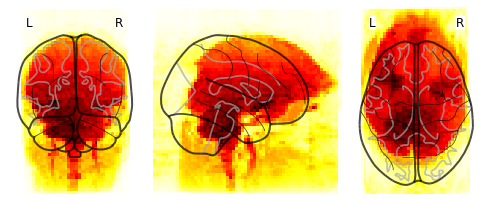

In [35]:
plotting.plot_glass_brain(mean_img(fmri_filename),
                          threshold=3,
                          #output_file= os.path.join(explanatory_fMRI_dir, 'glass_brain_white.png')
                          )
plotting.show()

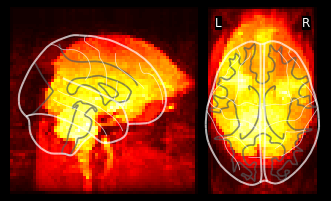

In [37]:
plotting.plot_glass_brain(
    mean_img(fmri_filename),
    black_bg=True,
    display_mode='xz',
    threshold=None,
    #output_file= os.path.join(explanatory_fMRI_dir, 'glass_brain_black.png')
   )

plotting.show()

## Stimuli Visualizations 

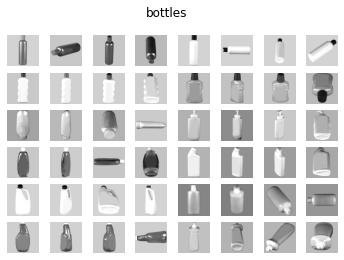

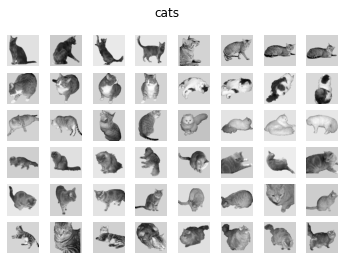

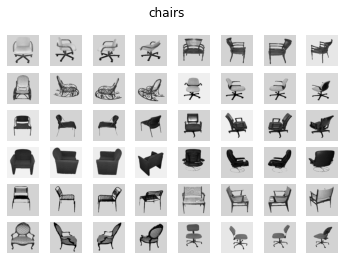

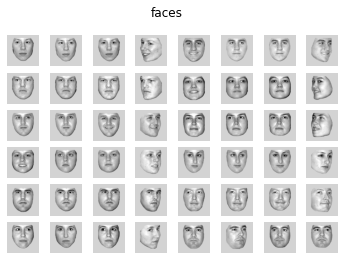

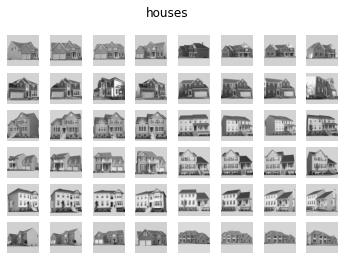

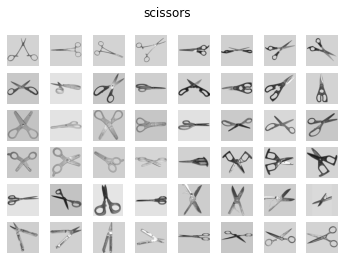

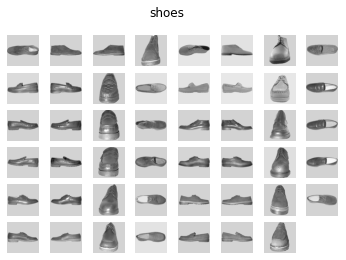

In [38]:
haxby_dataset_stimuli = datasets.fetch_haxby(subjects=[], fetch_stimuli=True)
stimulus_information = haxby_dataset_stimuli.stimuli

for stimulus_type in [*stimulus_information]:
    
    if stimulus_type != 'controls':

        img_paths = stimulus_information[stimulus_type]
        
        fig, axes = plt.subplots(6, 8)
        fig.suptitle(stimulus_type)

        for img_path, ax in zip(img_paths, axes.ravel()):
            image = plt.imread(img_path)
            ax.imshow(image, cmap='gray')

        for ax in axes.ravel():
            ax.axis("off")
            
            
        #fig.savefig(os.path.join(explanatory_fMRI_dir, f'{stimulus_type}.png')) 

plt.show()
    
    

# Interactive Brain Visualizations 

##  3D Plots of statistical maps on the cortical surface

In [ ]:
plotting.view_img_on_surf(mean_img(fmri_filename), threshold='90%', surf_mesh='fsaverage') 

In [ ]:
plotting.view_img_on_surf(mean_img(fmri_filename), threshold='70%', surf_mesh='fsaverage') 

## Brain Marking

In [ ]:
plotting.view_markers( 
[(0, -52, 18), (-46, -68, 32), (46, -68, 32), (1, 50, -5)],
['red', 'cyan', 'magenta', 'orange'],
marker_size=10) 

## Decoding Label Analysis and Masking 

In [42]:
# Load behavioral information
behavioral = pd.read_csv(haxby_dataset.session_target[0], delimiter=' ')
behavioral.head()

,labels,chunks
0,rest,0
1,rest,0
2,rest,0
3,rest,0
4,rest,0


In [43]:
# Visual Stimuli Categories:
for stimuli in np.unique(behavioral['labels']).tolist():
    print(stimuli)

bottle
cat
chair
face
house
rest
scissors
scrambledpix
shoe


In [6]:
stimuli_categories = [
                        'scissors',
                        'face', 
                        'cat',
                        'scrambledpix',
                        'bottle',
                        'chair',
                        'shoe',
                        'house'
]

### Masking Spatio Temporal Code and Its Target 

In [45]:
# Creating conditional categories:
conditions = behavioral['labels']

# We ignore rest condition:
condition_mask = conditions.isin(stimuli_categories).tolist()


fmri_niimgs = index_img(fmri_filename, condition_mask)

conditions = conditions[condition_mask]

# Convert to numpy array
conditions = conditions.values
print(conditions.shape)

(864,)


Spatio-temporal Masked data shape: (temporal dimension, spatial dimension 1, spatial dimension 2, # of experiments)

In [48]:
# (temporal dimension, spatial dimension 1, spatial dimension 2, # of experiments)
fmri_niimgs.get_data().shape

(40, 64, 64, 864)

Spatio-temporal Un-masked data shape: (temporal dimension, spatial dimension 1, spatial dimension 2, # of experiments)

In [50]:
spatio_temporal_data = fetch_from_haxby(haxby_dataset.func[subject_id])
spatio_temporal_data.shape

(40, 64, 64, 1452)

In [51]:
for subject_id in range(num_subjects):
    label = pd.read_csv(haxby_dataset.session_target[subject_id], delimiter=' ')
    
    # Creating conditional categories:
    conditions = behavioral['labels']

    condition_mask = conditions.isin(stimuli_categories).tolist()
    conditions = conditions[condition_mask]
    
    # Convert to numpy array
    conditions = conditions.values
    print(conditions.shape)   

(864,)
(864,)
(864,)
(864,)
(864,)
(864,)


# Creatining fMRI Data Matrices for each Subject

In [7]:
# Creating stimuli to category and category to stimuli:
stimuli2category = {
                        'scissors'     : 0,
                        'face'         : 1, 
                        'cat'          : 2,
                        'scrambledpix' : 3,
                        'bottle'       : 4,
                        'chair'        : 5,
                        'shoe'         : 6,
                        'house'        : 7
}

category2stimuli = {category:stimuli for stimuli, category in stimuli2category.items()}

## Spatio-Temporal Masking

In [8]:
def fetch_haxby_per_subject(subject_id:int = None,standardize:bool = True) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    
        Given the subject id, fetch the haxby data in matrix format.
        
        Arguments:
            - subject_id  (int) : Subject number from [1,6]
            - standardize (bool): If true, masks are standardized
            
        Returns:
            - data (Tuple[np.ndarray, np.ndarray, np.ndarray]) = Original 4-D data, Flattened + Masked Data, Label  
    
    """
        
    # Getting the data file name:
    spatio_temporal_data_path = haxby_dataset.func[subject_id]  
   
    # Getting labels:
    behavioral = pd.read_csv(haxby_dataset.session_target[subject_id], delimiter = ' ')
    
    # Creating conditional categories:
    conditions = behavioral['labels']
    
    # Creating masks for stimuli categories, (ignores rest conditions)
    condition_mask = conditions.isin([*stimuli2category]).tolist()
    
    # Appylying masks to labels (categorical):
    conditions = conditions[condition_mask]
    
    # Creating labels series (numerical):
    categories = np.array([stimuli2category[stimulus] for stimulus in conditions])
    
    # Masking fMRI images: (shape = (40, 64, 64, 864))
    fmri_niimgs = index_img(spatio_temporal_data_path, condition_mask)
    
    # Converting NumPy and transposing to (864, 40, 64, 64):
    numpy_fmri = fmri_niimgs.get_data().transpose(3,0,1,2)
    
    masker = NiftiMasker(mask_img=haxby_dataset.mask_vt[subject_id],
                         smoothing_fwhm=4,
                         standardize=standardize,
                         memory='nilearn_cache',
                         memory_level=1)

    masked = masker.fit_transform(fmri_niimgs)
    
    
    return numpy_fmri,  masked, categories

In [105]:
data = [fetch_haxby_per_subject(subject_id) for subject_id in range(num_subjects)]
fmri_imgs_mat, masks, categories = list(zip(*data))

# Saving the data for future use:
save(fmri_imgs_mat, 'fMRI_data')
save(masks, 'masked_data')
save(categories, 'labels')

In [102]:
# Loading:
fmri_imgs_mat, masks, categories = load('fMRI_data'), load('masked_data'), load('labels')

# 4-D fMRI Data Similarity Analysis

## Functional Connectivity

### Correlation 

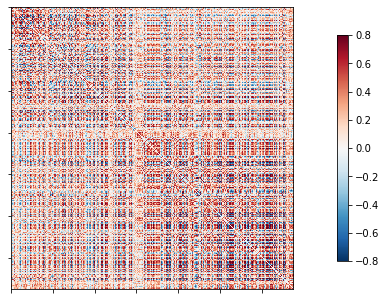

In [59]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([masks[subject_id]])[0]

fig = plt.figure()

# Mask out the major diagonal
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix,
                     colorbar=True,
                     vmax=0.8, vmin=-0.8,
                     figure = fig)
plotting.show()

fig.savefig(os.path.join(explanatory_fMRI_dir, 'correlation.png'))

### Precision 

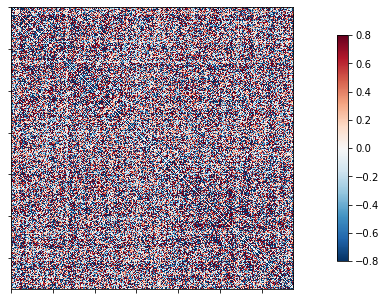

In [61]:
correlation_measure = ConnectivityMeasure(kind='precision')
correlation_matrix = correlation_measure.fit_transform([masks[subject_id]])[0]

fig = plt.figure()

# Mask out the major diagonal
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, colorbar=True,
                     vmax=0.8,
                     vmin=-0.8,
                     figure = fig)
plotting.show()


fig.savefig(os.path.join(explanatory_fMRI_dir, 'precision.png'))

### Partial Correlation 

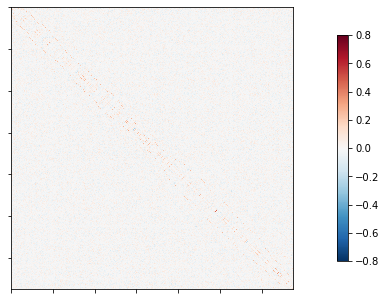

In [62]:
correlation_measure = ConnectivityMeasure(kind='partial correlation')
correlation_matrix = correlation_measure.fit_transform([masks[subject_id]])[0]
fig = plt.figure()

# Mask out the major diagonal
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, colorbar=True,
                     vmax=0.8, vmin=-0.8,figure = fig)
plotting.show()
fig.savefig(os.path.join(explanatory_fMRI_dir, 'partial_correlation.png'))

### Cosine 

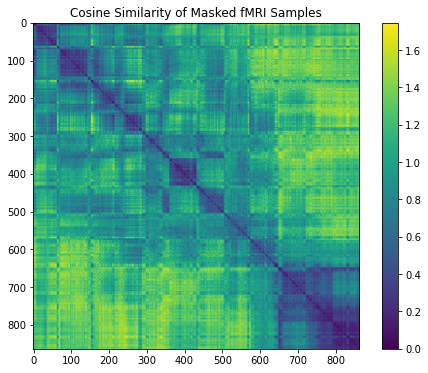

In [65]:
fig = plt.figure(figsize=(8,6))
plt.imshow(cdist(masks[subject_id], masks[subject_id], metric='cosine'))
plt.colorbar()
plt.title('Cosine Similarity of Masked fMRI Samples')
plt.show()
fig.savefig(os.path.join(explanatory_fMRI_dir, 'cosine.png'))

###  Minkowski

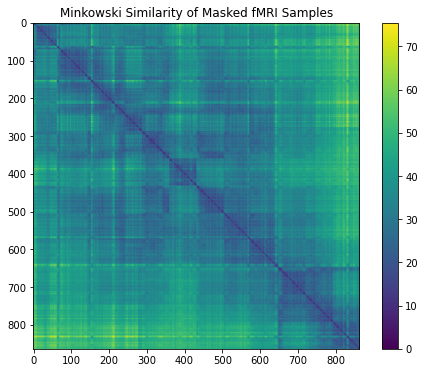

In [66]:
fig = plt.figure(figsize=(8,6))
plt.imshow(cdist(masks[subject_id], masks[subject_id], metric='minkowski'))
plt.colorbar()
plt.title('Minkowski Similarity of Masked fMRI Samples')
plt.show()
fig.savefig(os.path.join(explanatory_fMRI_dir, 'minkowski.png'))

### Euclidean

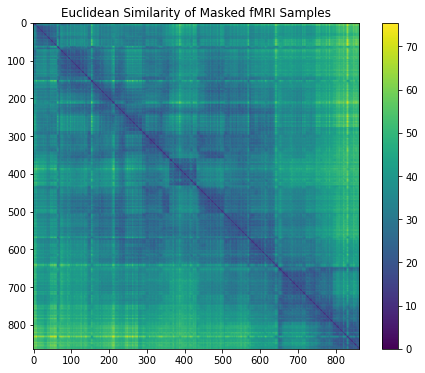

In [67]:
fig = plt.figure(figsize=(8,6))
plt.imshow(cdist(masks[subject_id], masks[subject_id]))
plt.colorbar()
plt.title('Euclidean Similarity of Masked fMRI Samples')
plt.show()
fig.savefig(os.path.join(explanatory_fMRI_dir, 'euclidean.png'))

#  Visual Stimuli Transformations


In [88]:
%%time

# Standardizing the data
scaler = StandardScaler()

# Normalizing data:
minmax_scaler =  MinMaxScaler()

Wall time: 0 ns


In [114]:
def plot_2d(component1:np.ndarray, component2:np.ndarray,path:str, y = None, ) -> None:
    
    fig = go.Figure(data=go.Scatter(
        x = component1,
        y = component2,
        mode='markers',
        marker=dict(
            size=20,
            color=y, #set color equal to a variable
            colorscale='Rainbow', # one of plotly colorscales
            showscale=True,
            line_width=1
        )
    ))
    fig.update_layout(margin=dict(l=100,r=100,b=100,t=100),width=2000,height=1200)                 
    fig.layout.template = 'plotly_dark'
    
    fig.show()
    
    
    fig.write_image(path)
    
def plot_3d(component1 : np.ndarray,
            component2 : np.ndarray,
            component3 :np.ndarray,
            path:str,
            y = None) -> None:
    
    fig = go.Figure(data=[go.Scatter3d(
            x=component1,
            y=component2,
            z=component3,
            mode='markers',
            marker=dict(
                size=10,
                color=y,                # set color to an array/list of desired values
                colorscale='Rainbow',   # choose a colorscale
                opacity=1,
                line_width=1
            )
        )])
    # tight layout
    fig.update_layout(margin=dict(l=50,r=50,b=50,t=50),width=1800,height=1000)
    fig.layout.template = 'plotly_dark'

    fig.show()
    fig.write_image(path)

def save_obj(obj:object, path:str = None) -> None:
    with open(path + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

        
def load_obj(path:str = None) -> object:
    with open(path + '.pkl', 'rb') as f:
        return pickle.load(f)

## PCA

In [ ]:
%%time

x = masks[subject_id]
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)

principal = pd.DataFrame(data = principalComponents
             ,columns = ['principal component 1',
                         'principal component 2',
                         'principal component 3'])

plot_2d(principalComponents[:, 0],
        principalComponents[:, 1],
        y = categories[subject_id],
        path = os.path.join(explanatory_fMRI_dir, 'pca_2d.png')
       )

In [ ]:
plot_3d(principalComponents[:, 0],
        principalComponents[:, 1],
        principalComponents[:, 2],
        path = os.path.join(explanatory_fMRI_dir, 'pca_3d.png'),
        y = categories[subject_id])

## T-Stochastic Neighboor Embedding (t-SNE)

In [ ]:
%%time

x = masks[subject_id]

tsne = TSNE(random_state = 42,
            n_components=3,
            verbose=0,
            perplexity=40,
            n_iter=400).fit_transform(x)

plot_2d(tsne[:, 0],
        tsne[:, 1],
        path = os.path.join(explanatory_fMRI_dir, 'tsene_2d.png'),
        y = categories[subject_id])

In [ ]:
plot_3d(tsne[:, 0],
        tsne[:, 1],
        tsne[:, 2],
        path = os.path.join(explanatory_fMRI_dir, 'tsene_3d.png'),
        y = categories[subject_id])

## Linear Discriminate Analysis

In [ ]:
%%time


x = masks[subject_id]
y = categories[subject_id]

X_LDA = LDA(n_components=3).fit_transform(x,y)

plot_3d(X_LDA[:, 0],
        X_LDA[:, 1],
        X_LDA[:, 2],
        path = os.path.join(explanatory_fMRI_dir, 'lda_3d.png'),
        y = categories[subject_id])

## Uniform Manifold Approximation and Projection (UMAP)

In [ ]:
%%time
#!pip uninstall umap
#!pip install umap-learn

import umap.umap_ as umap

reducer = umap.UMAP(random_state=42,n_components=3)
embedding = reducer.fit_transform(x)


plot_3d(embedding[:, 0],
        embedding[:, 1],
        embedding[:, 2],
         path = os.path.join(explanatory_fMRI_dir, 'umap_3d.png'),
        y = categories[subject_id])

## Independent Component Analysis (ICA)

In [ ]:
%%time

fast_ica = FastICA(n_components = 3)
ICs = fast_ica.fit_transform(x)


plot_3d(ICs[:, 0],
        ICs[:, 1],
        ICs[:, 2],
        path = os.path.join(explanatory_fMRI_dir, 'ica_3d.png'),
        y = categories[subject_id])

## Non-Negative Matrix Factorization

In [ ]:
%%time

nmf = NMF(n_components = 3, max_iter=500)
MFs = nmf.fit_transform(minmax_scaler.fit_transform(x))

plot_3d(MFs[:, 0],
        MFs[:, 1],
        MFs[:, 2],
         path = os.path.join(explanatory_fMRI_dir, 'nnmf_3d.png'),
        y = categories[subject_id])

## ISOMAP

In [ ]:
from sklearn.manifold import Isomap
x = masks[subject_id]

embedding = Isomap(n_components=3)
manifold = embedding.fit_transform(x)


plot_3d(manifold[:, 0],
        manifold[:, 1],
        manifold[:, 2],
        path = os.path.join(explanatory_fMRI_dir, 'isomap_3d.png'),
        y = categories[subject_id])

##   Locally Linear Embedding

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding


embedding = LocallyLinearEmbedding(n_components=3)
manifold = embedding.fit_transform(x,categories[subject_id])


plot_3d(manifold[:, 0],
        manifold[:, 1],
        manifold[:, 2],
        path = os.path.join(explanatory_fMRI_dir, 'lle_3d.png'),
        y = categories[subject_id])

## Multidimensional scaling 

In [ ]:
from sklearn.manifold import MDS


embedding = MDS(n_components=3)
manifold = embedding.fit_transform(x,categories[subject_id])


plot_3d(manifold[:, 0],
        manifold[:, 1],
        manifold[:, 2],
        path = os.path.join(explanatory_fMRI_dir, 'mds_3d.png'),
        y = categories[subject_id])

## Spectral Embedding 

In [ ]:
from sklearn.manifold import SpectralEmbedding


embedding = SpectralEmbedding(n_components=3)
manifold = embedding.fit_transform(x)


plot_3d(manifold[:, 0],
        manifold[:, 1],
        manifold[:, 2],
        path = os.path.join(explanatory_fMRI_dir, 'SpectralEmbedding_3d.png'),
        y = categories[subject_id])

We can see among the linear and non-linear manifold learning algorithms, best seperation is found with LDA

# Classical ML Algorithms

##   One Shot ML Classifiers

Applied Algorithms:

    * LinearSVC
    * SGDClassifier
    * MLPClassifier
    * Perceptron
    * LogisticRegression
    * LogisticRegressionCV
    * SVC
    * CalibratedClassifierCV
    * PassiveAggressiveClassifier
    * LabelPropagation
    * LabelSpreading
    * RandomForestClassifier
    * GradientBoostingClassifier
    * QuadraticDiscriminantAnalysis
    * RidgeClassifierCV
    * RidgeClassifier
    * AdaBoostClassifier
    * ExtraTreesClassifier
    * KNeighborsClassifier
    * BaggingClassifier
    * BernoulliNB
    * LinearDiscriminantAnalysis
    * GaussianNB
    * NuSVC
    * DecisionTreeClassifier
    * NearestCentroid
    * ExtraTreeClassifier
    * CheckingClassifier
    * DummyClassifier 

In [ ]:
%%time

# Loading:
fmri_imgs_mat, masks, categories = load('fMRI_data'), load('masked_data'), load('labels')


predictions_per_subject = list()


for subject_id, (mask, category) in enumerate(zip(masks, categories)):
    
    print(f'Subject id: {subject_id}')
  
    X_train, X_test, y_train, y_test = train_test_split(mask, category, test_size=0.3, random_state=42)
    
    clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit(X_train, X_test, y_train, y_test)    
    
    models.to_csv(os.path.join(results_dir, f'Subject_{subject_id}_lazy_results.csv'))

    print(models)

## FREM : Ensembling of Regularized Models for Robust Decoding (SVC - L2)

FREM uses an implicit spatial regularization through fast clustering and aggregates a high number of estimators trained on various splits of the training set, thus returning a very robust decoder at a lower computational cost than other spatially regularized methods

---

FREM ensembling procedure yields an important improvement of decoding accuracy on this simple example compared to fitting only one model per fold and the clustering mechanism keeps its computational cost reasonable even on heavier examples. Here we ensembled several instances of l2-SVC, but FREMClassifier also works with ridge or logistic. 

In [ ]:
from nilearn.decoding import FREMClassifier
from nilearn.image import index_img
    
models_path = os.path.join(root_dir, 'models')
num_subjects = 6

for subject_id in range(num_subjects):
    
    print(f'Subject id: {subject_id}')

    behavioral = pd.read_csv(haxby_dataset.session_target[subject_id], sep=" ")

    conditions = behavioral['labels']
    condition_mask = conditions.isin([*stimuli2category])

    # Split data into train and test samples, using the chunks
    condition_mask_train = (condition_mask) & (behavioral['chunks'] <= 8)
    condition_mask_test = (condition_mask) & (behavioral['chunks'] > 8)
   
   
    filenames = haxby_dataset.func[subject_id]
    X_train = index_img(filenames, condition_mask_train)
    X_test = index_img(filenames, condition_mask_test)
    y_train = conditions[condition_mask_train].values
    y_test = conditions[condition_mask_test].values    
    
    masker = NiftiMasker(mask_img=haxby_dataset.mask_vt[subject_id],
                         smoothing_fwhm=4,
                         standardize=True,
                         memory='nilearn_cache',
                         memory_level=1)

    #masked = masker.fit_transform(fmri_niimgs)
    
    
    decoder = FREMClassifier(estimator='svc', cv=10, mask = masker)

    # Fit model on train data and predict on test data
    decoder.fit(X_train, y_train)

    y_pred = decoder.predict(X_test)
    
    report = pd.DataFrame(classification_report(y_test, y_pred, output_dict = True)).T      
    report.to_csv(os.path.join(results_dir, f'Subject_{subject_id}_FREM_results.csv')) 
    
    scores = pd.DataFrame(decoder.cv_scores_).T
    scores.to_csv(os.path.join(results_dir, f'Subject_{subject_id}_FREMCV_results.csv')) 
    
    save_obj(decoder, os.path.join(models_path, f'Subject_{subject_id}_FREM_model'))   

## FREM : Ensembling of Regularized Models for Robust Decoding (Logistic Regression - L2)

In [ ]:
from nilearn.decoding import FREMClassifier
from nilearn.image import index_img
from sklearn.model_selection import LeaveOneGroupOut
cv = LeaveOneGroupOut()  
models_path = os.path.join(root_dir, 'models')
num_subjects = 6

for subject_id in range(num_subjects):
    
    print(f'Subject id: {subject_id}')

    behavioral = pd.read_csv(haxby_dataset.session_target[subject_id], sep=" ")

    conditions = behavioral['labels']
    condition_mask = conditions.isin([*stimuli2category]) 
    
    filenames = haxby_dataset.func[subject_id]
    X_train = index_img(filenames, condition_mask)  
    y_train = conditions[condition_mask].values
    
    decoder = FREMClassifier(estimator='logistic_l2',
                             cv=10,
                             mask = NiftiMasker(mask_img=haxby_dataset.mask_vt[subject_id],
                                                 smoothing_fwhm=4,
                                                 standardize=True,
                                                 memory='nilearn_cache',
                                                 memory_level=1)
                            )

    # Fit model on train data and predict on test data:
    decoder.fit(X_train, y_train)
    
    # Saving:
    scores = pd.DataFrame(decoder.cv_scores_).T
    scores.to_csv(os.path.join(results_dir, f'Subject_{subject_id}_FREMLogisticRegressionCV_results.csv'))     
    save_obj(decoder, os.path.join(models_path, f'Subject_{subject_id}_FREMLogisticRegressionCV_model'))   

Subject id: 0
Subject id: 1


# ML Visualizations

## Statistical Map Visualizations for ML Classifiers

In [425]:
image_results_dir = os.path.join(root_dir,'images/results')

subject_id = 5
decoder = load_obj(os.path.join(models_path, f'Subject_{subject_id}_FREM_model'))

weight_img = decoder.coef_img_["face"]
filenames = haxby_dataset.func[subject_id]


plotting.plot_stat_map(weight_img,
                       bg_img = mean_img(filenames),
                       title=f"FREM: Accuracy Score for Face Stimuli: {np.mean(decoder.cv_scores_['face']).round(2)}",
                       cut_coords=(-52, -5),
                       display_mode="yz",
                       output_file= os.path.join(image_results_dir, 'FREM_face.png'),
                       )

plotting.show()

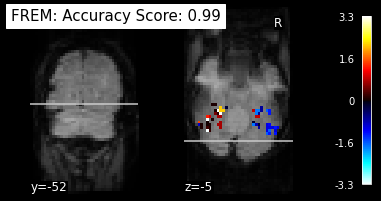

In [422]:
subject_id = 5
decoder = load_obj(os.path.join(models_path, f'Subject_{subject_id}_FREM_model'))

weight_img = decoder.coef_img_["house"]
filenames = haxby_dataset.func[subject_id]

plotting.plot_stat_map(weight_img,
                       bg_img = mean_img(filenames),
                       title=f"FREM: Accuracy Score: {np.mean(decoder.cv_scores_['house']).round(2)}",
                       cut_coords=(-52, -5),
                       #output_file= os.path.join(image_results_dir, 'FREM_house.png'),
                       display_mode="yz")



plotting.show()

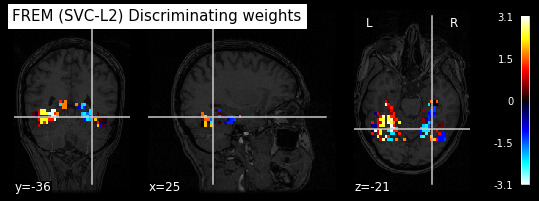

In [432]:
subject_id = 0
decoder = load_obj(os.path.join(models_path, f'Subject_{subject_id}_FREM_model'))

weight_img = decoder.coef_img_["face"]


plotting.plot_stat_map(weight_img,
                       bg_img=haxby_dataset.anat[subject_id],
                       title='FREM (SVC-L2) Discriminating weights',
                       #output_file= os.path.join(image_results_dir, 'FREM (SVC-L2) Discriminating weights.png'),
                       )

plotting.show()

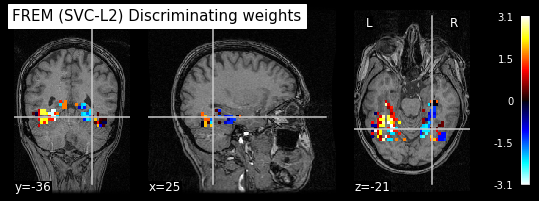

In [437]:
subject_id = 0
decoder = load_obj(os.path.join(models_path, f'Subject_{subject_id}_FREM_model'))

weight_img = decoder.coef_img_["face"]


plotting.plot_stat_map(weight_img,
                       bg_img=haxby_dataset.anat[subject_id],
                       title='FREM (SVC-L2) Discriminating weights',
                       dim = -1,
                       #output_file= os.path.join(image_results_dir, 'FREM (SVC-L2) Discriminating weights anat.png')
                      )

plotting.show()

# ML Classifiers Accuracy Visualizations

# Deep Learning Algorithms

In [12]:
!pip install vit-pytorch

In [44]:
!conda install pytorch torchvision torchaudio cpuonly -c pytorch

^C


In [45]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from PIL import Image


# PyTorch's versions:
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

# We will be working with GPU:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device : ' , device)

# Number of GPUs available. 
num_GPU = torch.cuda.device_count()
print('Number of GPU : ', num_GPU)


# Creating stimuli to category and category to stimuli:
stimuli2category = {
                        'scissors'     : 0,
                        'face'         : 1, 
                        'cat'          : 2,
                        'scrambledpix' : 3,
                        'bottle'       : 4,
                        'chair'        : 5,
                        'shoe'         : 6,
                        'house'        : 7
}

category2stimuli = {category:stimuli for stimuli, category in stimuli2category.items()}

PyTorch Version:  1.7.1+cpu
Torchvision Version:  0.8.2
Device :  cpu
Number of GPU :  0


# Preparing fMRI Data for  Batch Processing

In [125]:
class fMRIDataset(torch.utils.data.Dataset):
    scaler = MinMaxScaler()
    def __init__(self, 
                 mode:str = 'fMRI',
                 transforms = None,
                 fetch_from_path:bool = True,
                 prepare_for_transformer:bool = False):
        
        assert mode in ['fMRI','mask'], 'Please provide fMRI or Mask type of mode!'
        
        self.transforms = transforms
        self.num_class = len(stimuli2category) or len(category2stimuli)

        self.batch_data_path = 'batch_fMRI'
        self.batch_label_path = 'batch_label'
        self.batch_mask_path = 'batch_masks'
        
        if prepare_for_transformer:
            self.batch_data_path = 'batch_fMRI_transformer'
            self.batch_data_path = 'batch_label_transformer'

        
        batched_data_path = os.path.join(root_dir, self.batch_data_path)
        bacthed_label_path = os.path.join(root_dir, self.batch_label_path)  
        bacthed_mask_path = os.path.join(root_dir, self.batch_mask_path)  
        
        
        if mode == 'fMRI':            
            if fetch_from_path: 
                if os.path.exists(batched_data_path + '.npy') and os.path.exists(bacthed_label_path  + '.npy'):   
                    
                    print(f'Data is fetching from {root_dir}')
                    self.data = load(batched_data_path)
                    self.labels = load(bacthed_label_path)   
                    
                else:
                    raise NoneError("Object not constructed. Cannot access a 'None' object.")
            else:
                              
                self.data = np.concatenate(load('fMRI_data'), axis = 0)
                self.labels = np.concatenate(load('labels'), axis = 0)
                
                if prepare_for_transformer:
                    self.prepare_transformer()
                    
                save(self.data, batched_data_path)
                save(self.labels, bacthed_label_path)                                    
            
        else:
            pass
                   

        
        assert self.labels.shape[0] == self.data.shape[0], ' # of Targets and Data samples does not match!'
            
    
    def prepare_transformer(self):
        self.data = self.data[:, 1:, :, :, ].reshape(-1, 64, 64, 3)                         
        self.labels = np.repeat(self.labels, repeats = 13, axis = 0)
-      
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        image = self.data[idx]
               
        
        if image.shape == torch.Size([64, 3, 64]):
            image = image.permute(1,0,2)
                 
        #assert image.shape == torch.Size([3, 64, 64]), 'Mismatch Image Dimension!'
            
        label = self.labels[idx].reshape(1,)
        label = torch.as_tensor(label, dtype=torch.int, device=device)
  
        if self.transforms is not None:
            image = self.transforms(image)
          
        return image, label     

In [ ]:
class Normalize():
    def __call__(self, image):
        max_val = image.max()
        return image / max_val
    
class TorchTensor():
    def __call__(self, image):
        return torch.as_tensor(image, dtype=torch.float, device=device)
        
class MeanNormalize():
    def __call__(self, image):
        return F.normalize(image)
    
# [batch * channel(# of channels of each image) * depth(# of frames) * height * width]
class Make3D():
    def __call__(self, image):        
        return image.unsqueeze(0)

In [127]:
transform = transforms.Compose([
                                #transforms.ColorJitter([0.9,0.9]),
                                #transforms.RandomGrayscale(p = 0.3),
                                #transforms.RandomAffine((-30,30)),
                                #transforms.RandomPerspective(),
                                #transforms.GaussianBlur(3),
                                #transforms.RandomHorizontalFlip(p = 0.2),
                                #transforms.RandomVerticalFlip(p = 0.2),

                                #Important parts, above can be ignored
                                #transforms.Resize((224,224)),
                                #transforms.CenterCrop(224),
                                Normalize(),
                                TorchTensor()    
                                #transforms.ToTensor(),
                                                                
])


fMRI_dataset = fMRIDataset(transforms = transform, fetch_from_path = True)


break_point = len(fMRI_dataset) - 100 
train_dataset = torch.utils.data.Subset(fMRI_dataset, indices = range(break_point))
val_dataset = torch.utils.data.Subset(fMRI_dataset, indices = range(break_point, len(fMRI_dataset)))

Data is fetching from C:\Users\Administrator\Desktop\VOR


In [159]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                          shuffle = False,
                                          batch_size = batch_size,
                                          drop_last = True,
                                          )

val_loader = torch.utils.data.DataLoader(dataset = val_dataset,
                                          shuffle = False,
                                          batch_size = batch_size,
                                          drop_last = True,
                                          )
x, y = next(iter(train_loader))

print(x.shape, x.dtype)
print(y.shape, y.dtype)

torch.Size([16, 40, 64, 64]) torch.float32
torch.Size([16, 1]) torch.int32


In [300]:
from torch_utils import utils_torch
def train_one_epoch(model, criterion, optimizer, data_loader, device, epoch, print_freq, apex=False):
    model.train()
    metric_logger = utils_torch.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils_torch.SmoothedValue(window_size=1, fmt='{value}'))
    metric_logger.add_meter('img/s', utils_torch.SmoothedValue(window_size=10, fmt='{value}'))

    header = 'Epoch: [{}]'.format(epoch)
    for image, target in metric_logger.log_every(data_loader, print_freq, header):
        start_time = time.time()
        image, target = image.to(device), target.to(device).squeeze(-1).long()
        output = model(image)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc1, acc5 = utils_torch.accuracy(output, target, topk=(1, 5))
        batch_size = image.shape[0]
        metric_logger.update(loss=loss.item(), lr=optimizer.param_groups[0]["lr"])
        metric_logger.meters['acc1'].update(acc1.item(), n=batch_size)
        metric_logger.meters['acc5'].update(acc5.item(), n=batch_size)
        metric_logger.meters['img/s'].update(batch_size / (time.time() - start_time))


def evaluate(model, criterion, data_loader, device, print_freq=100):
    model.eval()
    metric_logger = utils_torch.MetricLogger(delimiter="  ")
    header = 'Test:'
    with torch.no_grad():
        for image, target in metric_logger.log_every(data_loader, print_freq, header):
            image = image.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True).squeeze(-1).long()
            output = model(image)
            loss = criterion(output, target)

            acc1, acc5 = utils_torch.accuracy(output, target, topk=(1,5))
            # FIXME need to take into account that the datasets
            # could have been padded in distributed setup
            batch_size = image.shape[0]
            metric_logger.update(loss=loss.item())
            metric_logger.meters['acc1'].update(acc1.item(), n=batch_size)
            metric_logger.meters['acc5'].update(acc5.item(), n=batch_size)
    # gather the stats from all processes
    metric_logger.synchronize_between_processes()

    print(' * Acc@1 {top1.global_avg:.3f} Acc@5 {top5.global_avg:.3f}'
          .format(top1=metric_logger.acc1, top5=metric_logger.acc5))
    return metric_logger.acc1.global_avg

## Models 

In [292]:
class Model(nn.Module):
    def __init__(self,model = None):
        super(Model,self).__init__()
        if model is not None:
            self.model = model    
        else:
            self.model = nn.Sequential(
            self.conv_block(40,  60,  0.1),
            self.conv_block(60,  80,  0.15),
            self.conv_block(80,  128, 0.25),
            self.conv_block(128, 256, 0.3),
            nn.Flatten(),
            self.linear_block(1024, 256, 0.4),
            self.linear_block(256, 128, 0.4),
            nn.Linear(128, 8)
)     

    def forward(self,img):    
        return self.model(img)  

    @staticmethod
    def conv_block(in_channel, out_channel, p):
        return nn.Sequential(
            nn.Conv2d(in_channel, out_channel, 3),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout2d(p)
            )

    @staticmethod
    def linear_block(in_ftrs,out_ftrs,p):
        return nn.Sequential(
            nn.Linear(in_ftrs,out_ftrs),
            nn.BatchNorm1d(num_features=out_ftrs),
            nn.ReLU(),
            nn.Dropout(p)
            )

net = Model().to(device)
print('Traniable parameter of the model: ' , sum(param.numel() for param in net.parameters() if param.requires_grad == True))
print(net)

Model(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(40, 60, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout2d(p=0.1, inplace=False)
    )
    (1): Sequential(
      (0): Conv2d(60, 80, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout2d(p=0.15, inplace=False)
    )
    (2): Sequential(
      (0): Conv2d(80, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout2d(p=0.25, inplace=F

## Creating Loss function, Optimizer, Scheduler (If any) 

In [293]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters())
# scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma = 0.7)

In [ ]:
# let's train it for 10 epochs
num_epochs = 10
print_freq = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(net, criterion, optimizer, train_loader, device, epoch, print_freq, apex=False)
    
    # update the learning rate
    scheduler.step()
    # evaluate on the test dataset
    evaluate(net, criterion, val_loader, device, print_freq)

print("That's it!")

## 3-D Convolutional Neural Network

In [280]:
class Model3D(nn.Module):
    def __init__(self, model = None):
        super(Model,self).__init__()
        if model is not None:
            self.model = model    
        else:
            self.conv3d = nn.Sequential(               
                            self.conv_block(1, 32, (3,3,3)),
                            self.conv_block(32, 64, (3,3,3)),
                            self.conv_block(64, 128, (3,3,3)),
                            self.conv_block(128, 512, (3,3,3)),
                            nn.Flatten()
            )           
            
            self.linear = nn.Sequential(
                            self.linear_block(1024,512,0.4),
                            self.linear_block(512,256,0.4),
                            nn.Linear(256, 8)
            ) 
            
            
            self.model = nn.Sequential(                                    
                           self.conv3d,
                           self.linear            
            )

    def forward(self,img):    
        return self.model(img)  

    @staticmethod
    def conv_block(in_channel, out_channel, p):
        return nn.Sequential(
            nn.Conv3d(in_channel,  out_channel,  (3,3,3) , (3,3,3)),
            nn.BatchNorm3d(out_channel),
            nn.ReLU(),
            nn.MaxPool3d(2,2),
            nn.Dropout3d(p)
            )

    @staticmethod
    def linear_block(in_ftrs,out_ftrs,p):
        return nn.Sequential(
            nn.Linear(in_ftrs,out_ftrs),
            nn.BatchNorm1d(num_features=out_ftrs),
            nn.ReLU(),
            nn.Dropout(p)
            )

net = Model().to(device)



# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters())
# scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma = 0.7)


# let's train it for 10 epochs
num_epochs = 10
print_freq = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(net, criterion, optimizer, train_loader, device, epoch, print_freq, apex=False)
    
    # update the learning rate
    scheduler.step()
    # evaluate on the test dataset
    evaluate(net, criterion, val_loader, device, print_freq)

print("That's it!")

Traniable parameter of the model:  750540
Wall time: 18.9 ms


## Visual Transformers 

In [303]:
%%time

from vit_pytorch import ViT

model = ViT(    image_size = 64,
                patch_size = 4,
                num_classes = fMRI_dataset.num_class,
                dim = 128,
                depth = 6,
                heads = 16,
                mlp_dim = 128,
                dropout = 0.1,
                emb_dropout = 0.1
).to(device)

# Test:
img = torch.randn(16, 3, 64, 64)

preds = model(x[:,1:,:,:].reshape(-1, 3, 64, 64)[:3])
preds.shape

Wall time: 2.4 s


torch.Size([3, 8])

In [ ]:
@torch.no_grad()
def predict(inputs):
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)  
      return preds
    

epochs = 20

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

# Results Interpretation

In [311]:
df1 = pd.read_csv(os.path.join(results_dir, 'Subject_0_lazy_results.csv'))

# Environmental

In [330]:
%env

{'ALLUSERSPROFILE': 'C:\\ProgramData',
 'APPDATA': 'C:\\Users\\Administrator\\AppData\\Roaming',
 'CAI_CAFT': 'c:\\Program Files (x86)\\CA\\SC\\CAM',
 'CAI_MSQ': 'c:\\Program Files (x86)\\CA\\SC\\CAM',
 'COMMONPROGRAMFILES': 'C:\\Program Files\\Common Files',
 'COMMONPROGRAMFILES(X86)': 'C:\\Program Files (x86)\\Common Files',
 'COMMONPROGRAMW6432': 'C:\\Program Files\\Common Files',
 'COMPUTERNAME': 'LT1201807681',
 'COMSPEC': 'C:\\WINDOWS\\system32\\cmd.exe',
 'CONDA_DEFAULT_ENV': 'base',
 'CONDA_EXE': 'D:\\Python\\Scripts\\conda.exe',
 'CONDA_PROMPT_MODIFIER': '(base) ',
 'CONDA_PYTHON_EXE': 'D:\\Python\\python.exe',
 'CONDA_ROOT': 'D:\\Python',
 'CONDA_SHLVL': '1',
 'CSAM_LOGGER_CONF': 'c:\\Program Files (x86)\\CA\\SC\\Csam\\SockAdapter\\cfg\\logger.cfg',
 'CSAM_SOCKADAPTER': 'c:\\Program Files (x86)\\CA\\SC\\Csam\\SockAdapter\\',
 'DRIVERDATA': 'C:\\Windows\\System32\\Drivers\\DriverData',
 'FPS_BROWSER_APP_PROFILE_STRING': 'Internet Explorer',
 'FPS_BROWSER_USER_PROFILE_STRING': 